/home/romuald/ENSEIGNEMENT/1-JupyterNotebooks/pyPhysChem



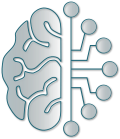

**Start at:** Friday 09 January 2026, 17:32:21  
**Hostname:** localhost.localdomain (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
# always run this cell
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color, fg, hl, bg 
vID.init(cwd0)

# Simulation of absorption UV-Vis spectra from TDDFT calculations

## Introduction

### TDDFT in short

<div class="introT">

**Time-Dependent Density Functional Theory** (TDDFT) is an extension of Density Functional Theory (DFT) that enables the study of **electronic excitations**. While DFT is primarily used to determine ground-state electronic properties, TDDFT extends its capabilities to describe how a system responds to time-dependent perturbations, such as an external electromagnetic field.

By solving the time-dependent Kohn-Sham (TDKS) equations within the linear-response framework, TDDFT allows the calculation of **excitation energies (or wavelengths)** and **oscillator strengths**. These quantities are essential for predicting electronic absorption spectra, making TDDFT a widely used method for simulating optical properties of molecules and materials.

</div>

### Practical Outcomes of TDDFT Calculations
<div class="intro">

From a practical perspective, **TDDFT calculations provide key spectroscopic properties of molecules and materials**, which can be directly compared with experimental data. The main outcomes include:

1. **Excitation Energies (Electronic Transition Energies)**
   - TDDFT predicts the **energy differences between the ground state and excited states**, typically reported in **electron volts (eV)** or as **wavelengths (nm)** in the UV-Vis spectrum.
   - 
   - These values correspond to the positions of absorption peaks in experimental spectra

2. **Oscillator Strengths (Transition Intensities)**
   - The oscillator strength quantifies the **probability of an electronic transition** occurring under light excitation
   - Higher oscillator strengths indicate more intense absorption peaks

3. **Excited-State Molecular Orbitals**
   - TDDFT provides insights into **which molecular orbitals are involved in electronic transitions** (e.g., π→π*, n→π*, charge-transfer (CT) transitions such as MLCT or LMCT in transition metal complexes)

</div>

### Purpose of this notebook
<div class="rqE">
    
In this notebook, we will use TDDFT to compute and visualize **UV-Vis absorption spectra** for molecular systems, extracting excitation energies, oscillator strengths, and transition character to aid in spectroscopic analysis.

This notebook uses TDDFT to simulate **Visible and Ultraviolet** absorption spectra, covering the **UV-Vis spectral range (~200–800 nm)**. This spectral region is critical for studying electronic transitions in molecules, including π→π*, n→π*, and charge-transfer excitations. The computed spectra provide insights into molecular electronic structure and can be compared with experimental absorption measurements.

Using Python-based functions, we will generate UV-Vis spectra, analyze the nature of the electronic transitions, and demonstrate the predictive power of TDDFT for spectroscopic applications.
</div>

### From TDDFT discrete vertical transitions to continuous UV-Vis absorption spectra

#### Chemical and physical origin of the broadening

<div class="intro">

**TDDFT calculations give discrete excitation lines**, whilst real spectra are broadened. Applying **Gaussian broadening** mimics the vibrational and inhomogeneous broadening seen in experimental spectra. This allows **direct comparison** between computed and experimental absorption spectra.

The **Gaussian broadening** applied to TDDFT results has a **physical and chemical origin** rooted in the real-world behavior of electronic transitions. In experimental UV-Vis spectra, absorption peaks are not **sharp delta functions** (as they are in raw TDDFT results) but rather **broadened bands** due to several factors:

- **Vibrational Broadening (Franck-Condon Effects)**
    - When a molecule absorbs a photon, it transitions from the ground state to an excited state. However, molecular vibrations affect this transition.
    - Instead of a single sharp excitation, the **Franck-Condon principle** dictates that multiple vibrational sublevels contribute to the absorption.
    - This results in a **Gaussian-like distribution** of intensities due to the population of different vibrational states.
- In **solution-phase spectroscopy**, molecules experience different **local environments** due to solvent interactions, leading to small variations in excitation energies.
- In **solid-state systems**, different molecular orientations and interactions with the matrix contribute to peak broadening.

The cumulative effect of vibrational and environmental contributions is a **distribution of transition energies**, which can be well-approximated by a Gaussian function.
</div>

#### Basic principle of a gaussian broadening

<div class="intro" >
    
By combining excitation energies and oscillator strengths, TDDFT can generate simulated absorption spectra, which can be directly compared to experimental UV-Vis spectra. This equation describes a Gaussian broadening function applied to a discrete electronic transition S<sub>0</sub> &rarr;S<sub>i</sub> characterized by $\bar{\nu}_{i}^{\mathrm{TDDFT}}$ and $\varepsilon_{i}^{\mathrm{TDDFT}}$ to generate a continuous UV-Vis absorption spectrum:
    
$$\varepsilon_{i}(\bar{\nu})=\varepsilon_{i}^{\mathrm{TDDFT}}\exp\left[-\left(\frac{\bar{\nu}-\bar{\nu}_{i}^{\mathrm{TDDFT}}}{\sigma}\right)^{2}\right]$$

In most cases, there will be more than one electronic excitation in the region of interest. The overall spectrum is obtained from the sum of all the individual bands:

$$\varepsilon(\bar{\nu}) = \sum_{i}^{N}\varepsilon_{i}(\bar{\nu})$$
It is demonstrated, in a [Gaussian whitepaper](https://gaussian.com/uvvisplot/), that the previous equation for $\varepsilon_{i}(\bar{\nu})$ becomes, in the cgs units system:
$$\varepsilon_{i}(\bar{\nu})=\frac{\sqrt{\pi}e^{2}N_{\mathrm{A}}}{1000\ln(10)c^{2}m_{e}}\frac{f_{i}}{\sigma}\exp\left[-\left(\frac{\bar{\nu}-\bar{\nu}_{i}}{\sigma}\right)^{2}\right]$$

where:
- $\varepsilon_i$ is the molar absorption coefficient, in units of L∙mol$^{-1}$∙cm$^{-1}$
- $f_i$ is the dimensionless oscillator strength
- $\sigma$, the half-width of the Gaussian band at each $\varepsilon^{\mathrm{max}}$, is in cm$^{-1}$
- $c$ is the speed of light in cm∙s$^{-1}$
- $N_\mathrm{A}$ is the Avogadro number, in mol$^{-1}$
- $m_e$ is the electron mass in g
- $e$ is the elementary charge, in electrostatic unit of charge (esu)

</div>

#### Example

<div class="intro" >

Let's assume a single π→π* vertical excitation, characterized by &lambda; = 280 nm and an oscillator strength = 0.4. The corresponding Gaussian band simulated with a &sigma; = 0.3 eV half-width is:

<figure><img src="./FiguresCreatedInNotebooks/UV-Vis/singleState-C.png/"  alt="simulated UV-Vis spectrum" style="width:700px">
<figcaption>Simulated UV-Vis spectrum</figcaption></figure> 

In such case, &epsilon;<sub>max</sub> is calculated to be approx. 21595 L mol<sup>-1</sup> cm<sup>-1</sup>
</div>

## Functions

### Code

In [3]:
# always run this cell
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
sigma = 0.3 #eV 0.4 eV is the default value in GaussView
eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
sigmanm = eV2nm/sigma
print(f"sigma = {sigma} eV -> sigmanm = {sigmanm:.1f} nm")

def epsiG(lambdaX,lambdai,fi,sigmanm):
    '''
    calculates a Gaussian band shape around a vertical transition
    input:
        - lambdaX = wavelength variable, in nm
        - lambdai = vertical excitation wavelength for i_th state, in nm
        - fi = oscillator strength for state i (dimensionless)
        - sigmanm = half-width of the Gaussian band, in nm
    output :
        molar absorption coefficient, in L mol-1 cm-1
    '''
    import scipy.constants as sc
    import numpy as np
    c = sc.c*1e2 #cm-1
    NA = sc.N_A #mol-1
    me = sc.m_e*1000 #g
    e = sc.e*sc.c*10 #elementary charge in esu 
    pf = np.sqrt(np.pi)*e**2*NA/(1000*np.log(10)*c**2*me)
    nubarX = 1e7 / lambdaX # nm to cm-1
    nubari = 1e7 / lambdai
    sigmabar = 1e7 / sigmanm
    epsi = pf * (fi / sigmabar) * np.exp(-((nubarX - nubari)/sigmabar)**2)
    return epsi

def Absorbance(eps,opl,cc):
    '''
    Calculates the Absorbance with the Beer-Lambert law
    input:
        - eps = molar absorption coefficient, in L mol-1 cm-1
        - opl = optical path length, in cm
        - cc = concentration of the attenuating species, in mol.L-1
    output :
        Absorbance, A (dimensionless)
    '''
    return eps*opl*cc

def sumStatesWithGf(wavel,wavelTAB,feTAB,sigmanm):
    '''
    '''
    import numpy as np
    sumInt = np.zeros(len(wavel))
    for l in wavel:
        for i in range(len(wavelTAB)):
            sumInt[np.argwhere(l==wavel)[0][0]] += epsiG(l,wavelTAB[i],feTAB[i],sigmanm)
    return sumInt

def FindPeaks(sumInt,height,prom=1):
    '''
    '''
    from scipy.signal import find_peaks
    peaks = find_peaks(sumInt, height = height, threshold = None, distance = 1, prominence=prom)
    PeakIndex = peaks[0][:]
    PeakHeight = peaks[1]['peak_heights'][:]
    return PeakIndex,PeakHeight

def pickPeak(wavel,peaksIndex,peaksH,color,shift=0.01,height=0.04,posAnnotation=0.02):
    '''
    '''
    s=shift
    h=height
    a=posAnnotation
    for i in range(len(peaksIndex)):
        x = wavel[peaksIndex[i]]
        y = peaksH[i]
        plt.vlines(x, y+s, y+s+h, colors=color, linestyles='solid')
        plt.annotate(f"{x:.1f}",xy=(x,y),xytext=(x,y+s+h+a),rotation=90,size=12,ha='center',va='bottom')
    return

def plotTDDFTSpectrum(wavel,sumInt,wavelTAB,feTAB,sigmanm,labelSpectrum,lambdamin=250,lambdamax=800,ylog=False,save=False,filename='TDDFT.png',colorS='#0000ff',colorT='#0000cf'):
    '''
    Called by plotEps_lambda_TDDFT. Plots a single simulated UV-Vis spectrum, i.e. after gaussian broadening, together with the TDDFT vertical transitions (i.e. plotted as lines)
    input:
        - wavel = array of gaussian-broadened wavelengths, in nm
        - sumInt = corresponding molar absorptiopn coefficients, in L. mol-1 cm-1
        - wavelTAB = wavelength of TDDFT, e.g. discretized, transitions
        - feTAB = TDDFT oscillator strength for each transition of wavelTAB
        - sigmanm = half-width of gaussian functions, in nm
        - labelSpectrum = will apear in the legend of the graph
        - ylog = y logarithmic axis (default: False)
    '''
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,8))
    plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='#2f6b91')
    if ylog:
        plt.ylabel('log(molar absorption coefficient / L mol$^{-1}$ cm$^{-1})$',size=14,fontweight='bold',color='#2f6b91')
    else:
        plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='#2f6b91')
    for i in range(len(wavelTAB)):
        if ylog:
            print(np.log(epsiG(wavelTAB[i],wavelTAB[i],feTAB[i],sigmanm)))
            plt.vlines(x = wavelTAB[i], ymin = 2, ymax = np.log(epsiG(wavelTAB[i],wavelTAB[i],feTAB[i],sigmanm)), colors = colorT)
        else:
            plt.vlines(x = wavelTAB[i], ymin = 0, ymax = epsiG(wavelTAB[i],wavelTAB[i],feTAB[i],sigmanm), colors = colorT)
    plt.xticks(fontsize=16,fontweight='bold')
    plt.yticks(fontsize=16,fontweight='bold')
    if ylog:
        plt.plot(wavel,np.log(sumInt),linewidth=3,linestyle='-',color=colorS,label=labelSpectrum)
    else:
        plt.plot(wavel,sumInt,linewidth=3,linestyle='-',color=colorS,label=labelSpectrum)
    plt.xlim(lambdamin,lambdamax)
    plt.legend(fontsize=14)
    
    peaks, peaksH = FindPeaks(sumInt,10)
    if ylog: peaksH=np.log(peaksH)
    pickPeak(wavel,peaks,peaksH,colorS,500,500,200)
    # s=500
    # h=500
    # a=200
    # for i in range(len(peaks)):
    #     x = wavel[peaks[i]]
    #     y = peaksH[i]
    #     plt.vlines(x, y+s, y+s+h, colors=colorS, linestyles='solid')
    #     plt.annotate(f"{x:.1f}",xy=(x,y),xytext=(x,y+s+h+a),rotation=90,size=12,ha='center',va='bottom')
    
    import matplotlib.ticker as ticker
    ax = plt.gca() # this is a way to deefined advanced plot options
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # sets a tick for every integer multiple of the base (here 250) within the view interval
    if save:
        plt.savefig(filename,dpi=300,transparent=True)
    plt.show()

def plotEps_lambda_TDDFT(datFile,lambdamin,lambdamax, title="TDDFT plot", tP = 10, sigma=0.3,\
                         ylog=False, save=False,filename='plotEps_lambda.png',colorS='#3e89be',colorVT='#469cd6'):
    '''
    Plots a TDDFT VUV simulated spectrum (vertical transitions and transitions summed with gaussian functions)
    between lambdamin and lambdamax (sum of states done in the range [lambdamin-50, lambdamlax+50] nm)
    input:
        - datFile: pathway and name to file generated by 'GParser Gaussian.log -S'
        - lambdamin, lambdamax: plot range
        - title: title of the spectrum plot (default = "TDDFT plot")
        - tP: threshold for finding the peaks (default = 10 L. mol-1 cm-1)
        - sigma: half-width of gaussian functions, in eV (default = 0.3 eV)
        - ylog: y logarithmic axis (default: False). UNDER DEVELOPMENT!
        - save: saves in a png file (300 dpi) if True (default = False)
        - filename: name of the png file (default = plotEps_lambda.png)
        - colorVT: color of the vertical transition line (default = '#469cd6')
        - colorS: color of the simulated spectrum (default ='#3e89be')
    '''

    import scipy.constants as sc
    # sigma = 0.3 #eV 0.4 eV is the default value in GaussView
    eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
    sigmanm = eV2nm/sigma

    istate,state,wavel,fe,SSq = np.genfromtxt(datFile,skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
    wavel = np.array(wavel)
    fe = np.array(fe)
    if wavel.size == 1:
        wavel = np.array([wavel])
        fe = np.array([fe])
    wvl = np.arange(lambdamin-50,lambdamax+50,1)
    sumInt = sumStatesWithGf(wvl,wavel,fe,sigmanm)
    plotTDDFTSpectrum(wvl,sumInt,wavel,fe,sigmanm,title,lambdamin,lambdamax,ylog,save,filename,colorS,colorVT)
    peaksI, peaksH = FindPeaks(sumInt,tP)
    print(f"{bg.LIGHTREDB}{title}{bg.OFF}")
    for i in range(len(peaksI)):
        print(f"peak {i:3}. {wvl[peaksI[i]]:4} nm. epsilon_max = {peaksH[i]:.1f} L mol-1 cm-1")
    return

def initializePlotA_lambda(plotW, plotH):
    fig, graph = plt.subplots(figsize=(plotW,plotH))
    plt.subplots_adjust(wspace=0)
    plt.xticks(fontsize=16,fontweight='bold')
    plt.yticks(fontsize=16,fontweight='bold')
    return fig, graph

def plotAbs_lambda_TDDFT(graph, datFiles, C0, lambdamin, lambdamax, Amax, titles, linestyles=[], annotateP=[], tP = 0.1, sigma=0.3, save=False, filename='plotA_lambda.png'):
    '''
    Plots a simulated TDDFT VUV absorbance spectrum (transitions summed with gaussian functions)
    between lambdamin and lambdamax (sum of states done in the range [lambdamin-50, lambdamlax+50] nm)
    input:
        - graph: name of the plot object
        - datFiles: list of pathway/name to files generated by 'GParser Gaussian.log -S'
        - C0: list of concentrations needed to calculate A = epsilon x l x c (in mol.L-1)
        - lambdamin, lambdamax: plot range (x axis)
        - Amax: graph limit (y axis)
        - titles: list of titles (1 per spectrum plot)
        - linestyles: list of line styles(default = "--", i.e. a dashed line)
        - annotateP: list of Boolean (annotate lambda max True or False. Default = True)
        - tP: threshold for finding the peaks (default = 0.1)
        - sigma: half-width of gaussian functions, in eV (default = 0.3 eV)
        - save: saves in a png file (300 dpi) if True (default = False)
        - filename: name of the png file (default = plotEps_lambda.png)
    '''
    if linestyles == []: linestyles = len(datFiles)*['--']
    if annotateP == []: annotateP = len(datFiles)*[True]
    
    import scipy.constants as sc
    eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
    sigmanm = eV2nm/sigma

    graph.set_xlabel('wavelength / nm',size=14,fontweight='bold',color='#2f6b91')
    graph.set_ylabel('Absorbance',size=14,fontweight='bold',color='#2f6b91')
    graph.set_xlim(lambdamin,lambdamax)
    graph.set_ylim(0,Amax)
    graph.tick_params(axis='both', labelsize=14,labelcolor='black')
    for tick in graph.xaxis.get_majorticklabels(): tick.set_fontweight('bold') #it is both powerful (you can specify the type of a specific tick) and annoying
    for tick in graph.yaxis.get_majorticklabels(): tick.set_fontweight('bold')
    wvl = np.arange(lambdamin-50,lambdamax+50,1)
    for f in range(len(datFiles)):
        istate,state,wavel,fe,SSq = np.genfromtxt(datFiles[f],skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
        sumInt = sumStatesWithGf(wvl,wavel,fe,sigmanm)
        Abs = Absorbance(sumInt,1,C0[f])
        plot=graph.plot(wvl,Abs,linewidth=3,linestyle=linestyles[f],label=f"{titles[f]}. TDDFT ($C_0$={C0[f]} mol/L)")
        peaksI, peaksH = FindPeaks(Abs,tP,0.01)
        if (annotateP[f]): pickPeak(wvl,peaksI,peaksH,plot[0].get_color(),0.01,0.04,0.02)
        print(f"{bg.LIGHTREDB}TDDFT. {titles[f]}{bg.OFF}")
        for i in range(len(peaksI)):
            print(f"peak {i:3}. {wvl[peaksI[i]]:4} nm. A = {peaksH[i]:.2f}")
    graph.legend(fontsize=14)
    return

def replotAbs_lambda_exp(graph, superpose, csvFiles, C0, lambdamin, lambdamax, Amax, titles, linestyles=[], annotateP=[], tP = 0.1, sigma=0.3, save=False, filename='plotA_lambda.png'):
    '''
    Plots an experimental VUV absorbance spectrum read from a csv file between lambdamin and lambdamax
    input:
        - graph: name of the plot object
        - superpose: False = plots a new graph, otherwise the plot is superposed to a previously created one
                     (probably with plotAbs_lambda_TDDFT())
        - csvfiles: list of pathway/name to experimental csvFiles (see examples for the format)
        - C0: list of experimental concentrations, i.e. for each sample
        - lambdamin, lambdamax: plot range (x axis)
        - Amax: graph limit (y axis)
        - titles: list of titles (1 per spectrum plot)
        - linestyles: list of line styles(default = "-", i.e. a continous line)
        - annotateP: list of Boolean (annotate lambda max True or False. Default = True)
        - tP: threshold for finding the peaks (default = 0.1)
        - sigma: half-width of gaussian functions, in eV (default = 0.3 eV)
        - save: saves in a png file (300 dpi) if True (default = False)
        - filename: name of the png file (default = plotEps_lambda.png)
    '''
    if linestyles == []: linestyles = len(csvFiles)*['-']
    if annotateP == []: annotateP = len(csvFiles)*[True]
    
    graph.set_prop_cycle(None)
    
    if not superpose:
        graph.set_xlabel('wavelength / nm',size=14,fontweight='bold',color='#2f6b91')
        graph.set_ylabel('Absorbance',size=14,fontweight='bold',color='#2f6b91')
        graph.set_xlim(lambdamin,lambdamax)
        graph.set_ylim(0,Amax)
        graph.tick_params(axis='both', labelsize=14,labelcolor='black')
        for tick in graph.xaxis.get_majorticklabels(): tick.set_fontweight('bold') #it is both powerful (you can specify the type of a specific tick) and annoying
        for tick in graph.yaxis.get_majorticklabels(): tick.set_fontweight('bold')
    for f in range(len(csvFiles)):
        wavel,Abs = np.genfromtxt(csvFiles[f],skip_header=1,unpack=True,delimiter=";")
        wavel *= 1e9
        plot=graph.plot(wavel,Abs,linewidth=3,linestyle=linestyles[f],label=f"{titles[f]}. exp ($C_0$={C0[f]} mol/L)")
        peaksI, peaksH = FindPeaks(Abs,tP,0.01)
        if (annotateP[f]): pickPeak(wavel,peaksI,peaksH,plot[0].get_color(),0.01,0.04,0.02)
        print(f"{bg.LIGHTREDB}exp. {titles[f]}{bg.OFF}")
        for i in range(len(peaksI)):
            print(f"peak {i:3}. {wavel[peaksI[i]]:4} nm. A = {peaksH[i]:.2f}")
    graph.legend(fontsize=14)

    return

sigma = 0.3 eV -> sigmanm = 4132.8 nm


### Documentation 

In [4]:
?plotEps_lambda_TDDFT

Signature:
plotEps_lambda_TDDFT(
    datFile,
    lambdamin,
    lambdamax,
    title='TDDFT plot',
    tP=10,
    sigma=0.3,
    ylog=False,
    save=False,
    filename='plotEps_lambda.png',
    colorS='#3e89be',
    colorVT='#469cd6',
)
Docstring:
Plots a TDDFT VUV simulated spectrum (vertical transitions and transitions summed with gaussian functions)
between lambdamin and lambdamax (sum of states done in the range [lambdamin-50, lambdamlax+50] nm)
input:
    - datFile: pathway and name to file generated by 'GParser Gaussian.log -S'
    - lambdamin, lambdamax: plot range
    - title: title of the spectrum plot (default = "TDDFT plot")
    - tP: threshold for finding the peaks (default = 10 L. mol-1 cm-1)
    - sigma: half-width of gaussian functions, in eV (default = 0.3 eV)
    - ylog: y logarithmic axis (default: False). UNDER DEVELOPMENT!
    - save: saves in a png file (300 dpi) if True (default = False)
    - filename: name of the png file (default = plotEps_lambda.png)
    - 

In [5]:
?plotAbs_lambda_TDDFT

Signature:
plotAbs_lambda_TDDFT(
    graph,
    datFiles,
    C0,
    lambdamin,
    lambdamax,
    Amax,
    titles,
    linestyles=[],
    annotateP=[],
    tP=0.1,
    sigma=0.3,
    save=False,
    filename='plotA_lambda.png',
)
Docstring:
Plots a simulated TDDFT VUV absorbance spectrum (transitions summed with gaussian functions)
between lambdamin and lambdamax (sum of states done in the range [lambdamin-50, lambdamlax+50] nm)
input:
    - graph: name of the plot object
    - datFiles: list of pathway/name to files generated by 'GParser Gaussian.log -S'
    - C0: list of concentrations needed to calculate A = epsilon x l x c (in mol.L-1)
    - lambdamin, lambdamax: plot range (x axis)
    - Amax: graph limit (y axis)
    - titles: list of titles (1 per spectrum plot)
    - linestyles: list of line styles(default = "--", i.e. a dashed line)
    - annotateP: list of Boolean (annotate lambda max True or False. Default = True)
    - tP: threshold for finding the peaks (default = 0.1)


In [6]:
?replotAbs_lambda_exp

Signature:
replotAbs_lambda_exp(
    graph,
    superpose,
    csvFiles,
    C0,
    lambdamin,
    lambdamax,
    Amax,
    titles,
    linestyles=[],
    annotateP=[],
    tP=0.1,
    sigma=0.3,
    save=False,
    filename='plotA_lambda.png',
)
Docstring:
Plots an experimental VUV absorbance spectrum read from a csv file between lambdamin and lambdamax
input:
    - graph: name of the plot object
    - superpose: False = plots a new graph, otherwise the plot is superposed to a previously created one
                 (probably with plotAbs_lambda_TDDFT())
    - csvfiles: list of pathway/name to experimental csvFiles (see examples for the format)
    - C0: list of experimental concentrations, i.e. for each sample
    - lambdamin, lambdamax: plot range (x axis)
    - Amax: graph limit (y axis)
    - titles: list of titles (1 per spectrum plot)
    - linestyles: list of line styles(default = "-", i.e. a continous line)
    - annotateP: list of Boolean (annotate lambda max True or False. 

### Simple application: generation of the simulated band of the introduction

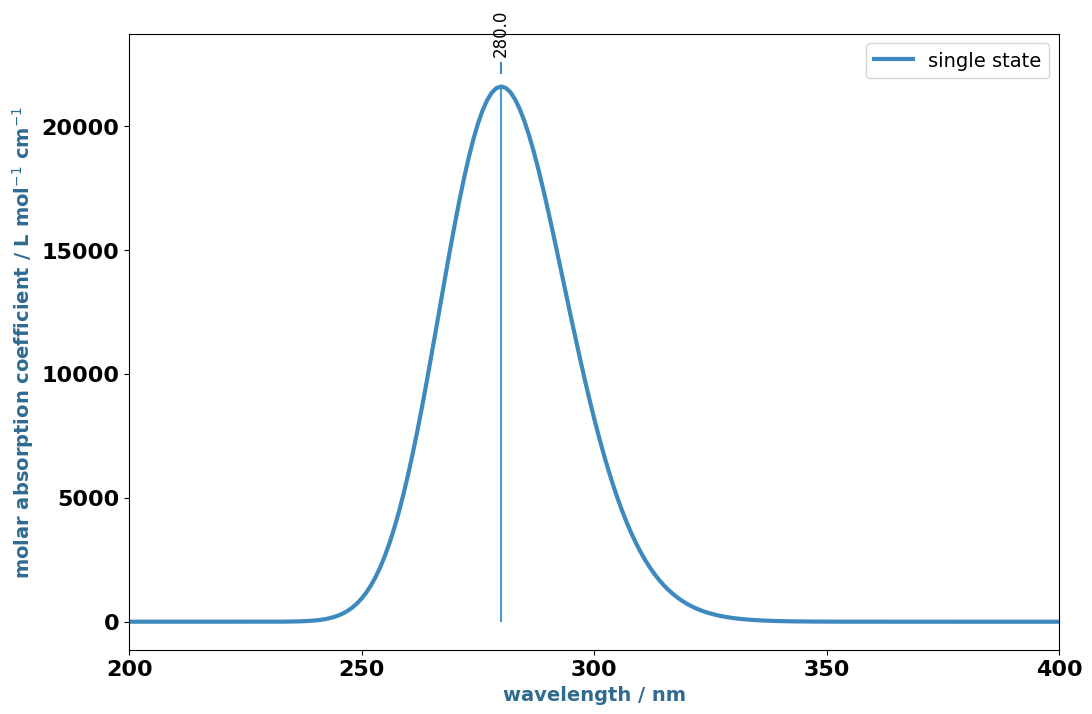

single state
peak   0.  280 nm. epsilon_max = 21594.7 L mol-1 cm-1


In [7]:
# create a fake spectrum at the GParser format
title = 'iState  State   lambda/nm    fe     S^2'
state1 = '1:   Singlet-A   280.0     0.4   0.000'
file = './EasterEgg/singleState.dat'
with open(file, 'w') as f:
    f.write(title+"\n")
    # f.write(state1+"\n")
    f.write(state1)

# plot epsilon = f(lambda)
plotEps_lambda_TDDFT(file,200,400,"single state", tP=10, sigma=0.3, save=True, filename='./FiguresCreatedInNotebooks/UV-Vis/singleState.png')

sigma = 0.3 eV -> sigmanm = 4132.8 nm


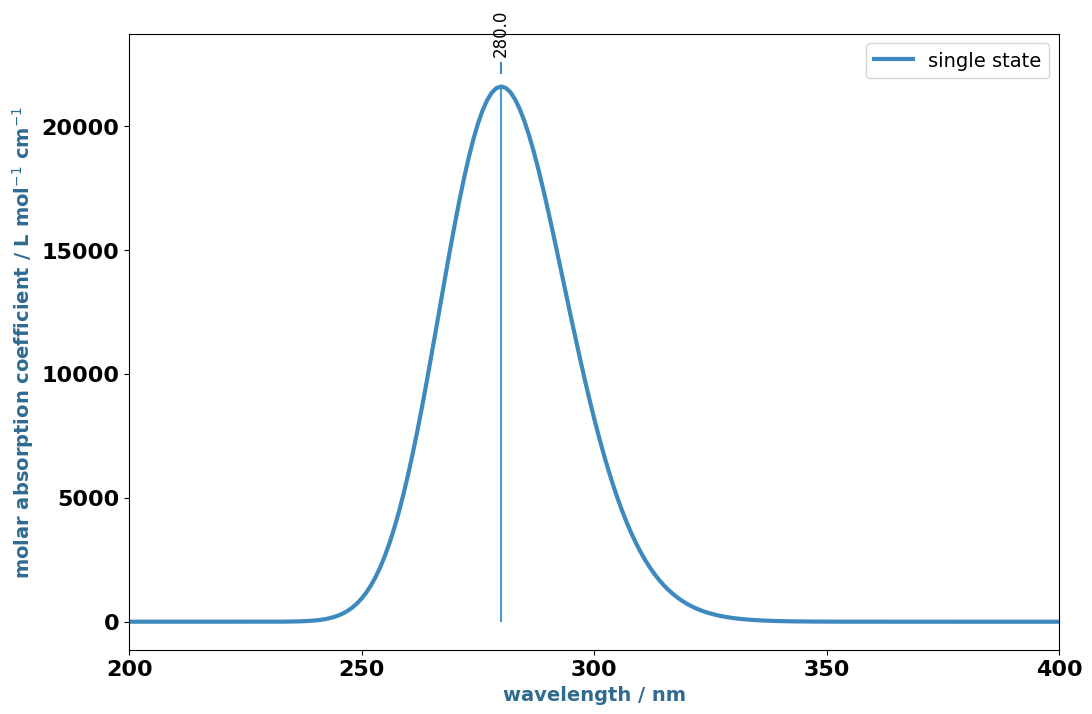

single state
peak   0.  280 nm. epsilon_max = 21594.7 L mol-1 cm-1


In [38]:
# Same as previous, but with the SpectrumSimulator class of tools4pyPhysChem
import tools4pyPhysChem
from tools4pyPhysChem import SpectrumSimulator
from importlib import reload
reload(tools4pyPhysChem)

sim = SpectrumSimulator()
sim.plotEps_lambda_TDDFT(file,200,400,"single state", tP=10, save=True, filename='./FiguresCreatedInNotebooks/UV-Vis/singleState.png')

## Examples
### Plot of epsilon = f($\lambda$)

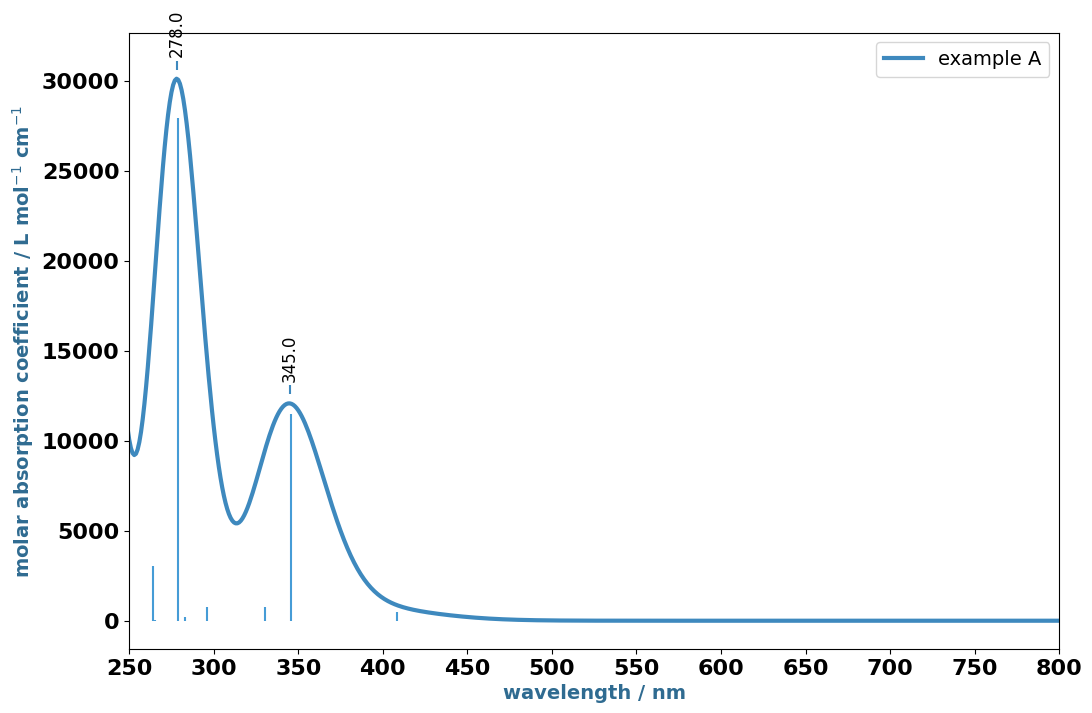

example A
peak   0.  231 nm. epsilon_max = 29301.0 L mol-1 cm-1
peak   1.  278 nm. epsilon_max = 30119.0 L mol-1 cm-1
peak   2.  345 nm. epsilon_max = 12077.1 L mol-1 cm-1


In [108]:
plotEps_lambda_TDDFT("./EasterEgg/test-tabA.dat",250,800,"example A", 10, 0.3, False)

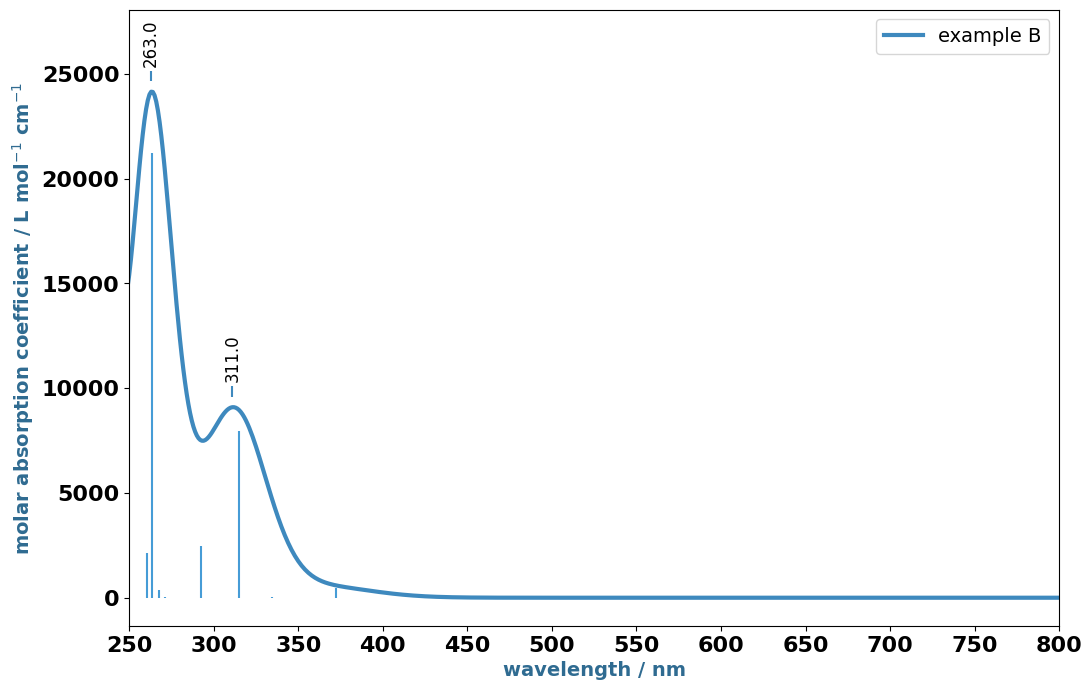

example B
peak   0.  228 nm. epsilon_max = 25724.3 L mol-1 cm-1
peak   1.  263 nm. epsilon_max = 24147.6 L mol-1 cm-1
peak   2.  311 nm. epsilon_max = 9091.4 L mol-1 cm-1


In [109]:
plotEps_lambda_TDDFT("./EasterEgg/test-tabB.dat",250,800, "example B",10,0.3,False)

sigma = 0.3 eV -> sigmanm = 4132.8 nm
epsMax =  30000
example B
peak   0.  228 nm. epsilon_max = 25724.3 L mol-1 cm-1
peak   1.  263 nm. epsilon_max = 24147.6 L mol-1 cm-1
peak   2.  311 nm. epsilon_max = 9091.4 L mol-1 cm-1


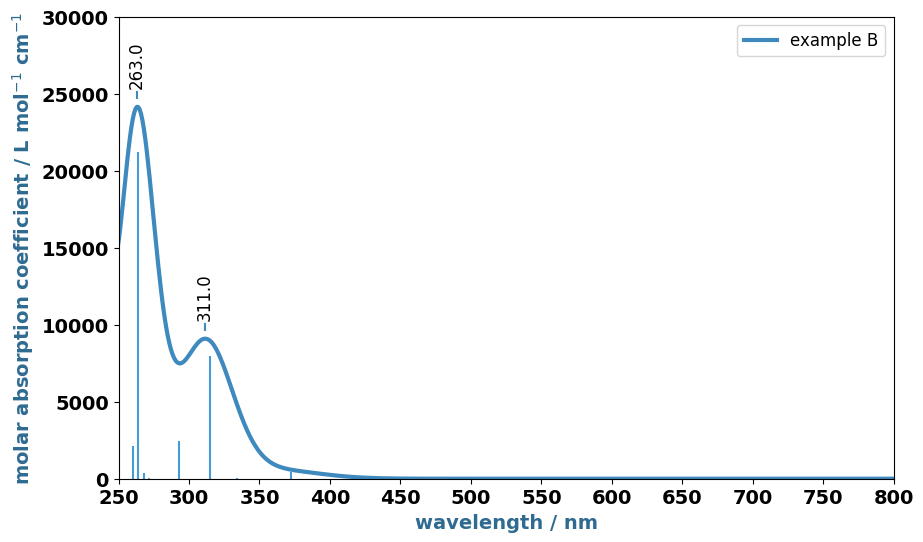

In [106]:
# Same as previous, but with the SpectrumSimulator class of tools4pyPhysChem
import tools4pyPhysChem
from tools4pyPhysChem import SpectrumSimulator
from importlib import reload
reload(tools4pyPhysChem)

sim = SpectrumSimulator(plotWH=(10,6))
sim.plotEps_lambda_TDDFT("./EasterEgg/test-tabB.dat",250,800,None,"example B",10,False)

### Plot of A = f($\lambda$)

TDDFT. test A
peak   0.  278 nm. A = 2.71
peak   1.  345 nm. A = 1.09
TDDFT. test B
peak   0.  263 nm. A = 2.17
peak   1.  311 nm. A = 0.82
exp. after irradiation [acetone]
peak   0. 362.0 nm. A = 0.84
peak   1. 558.0 nm. A = 1.46
exp. after irradiation [ethanol]
peak   0. 350.0 nm. A = 0.20
peak   1. 536.0 nm. A = 0.23


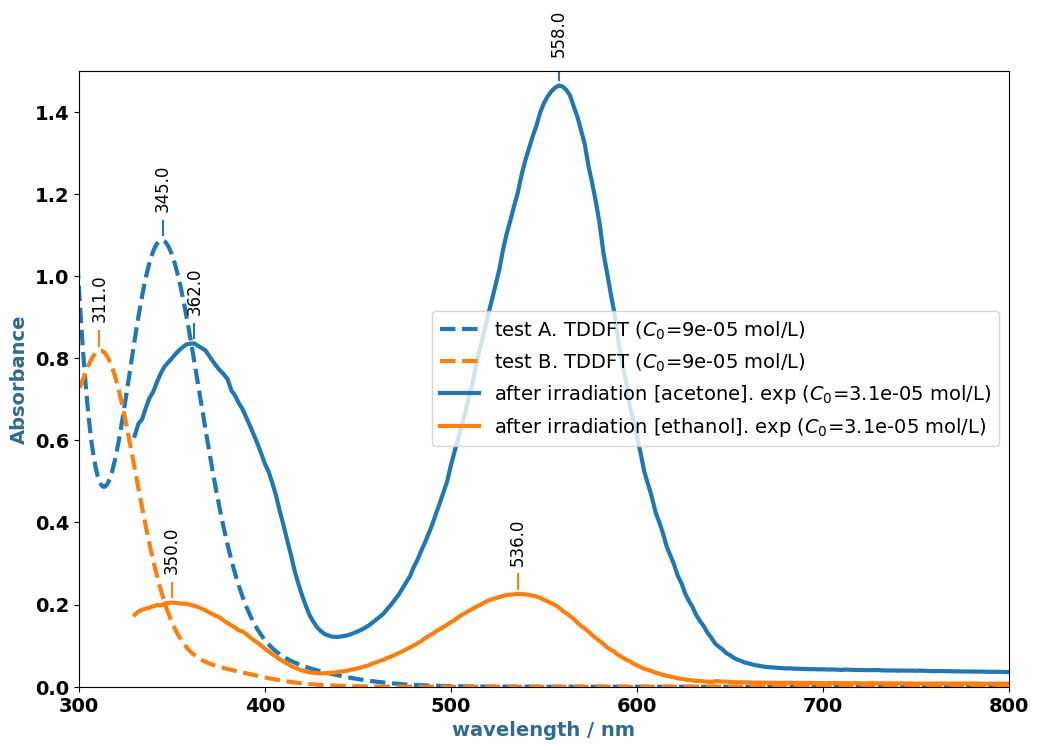

In [116]:
#### Both for TDDFT and exp spectra
fig, graph = initializePlotA_lambda(12, 8)
lambdaMin = 300
lambdaMax = 800
Amax = 1.5

#### TDDFT
datFilesTDDFT = ["./EasterEgg/test-tabA.dat","./EasterEgg/test-tabB.dat"]
C0theo = [9e-5]*2
titlesTDDFT = ["test A", "test B"]
plotAbs_lambda_TDDFT(graph, datFilesTDDFT, C0theo, lambdaMin, lambdaMax, Amax, titlesTDDFT)

#### exp
csvFilesExp = ["./EasterEgg/ExpAbsSpectrumAc.csv","./EasterEgg/ExpAbsSpectrumEtOH.csv"]
C0exp = [3.1e-5]*2
titlesExp = ["after irradiation [acetone]", "after irradiation [ethanol]"]
replotAbs_lambda_exp(graph, True, csvFilesExp, C0exp, lambdaMin, lambdaMax, Amax, titlesExp)

sigma = 0.3 eV -> sigmanm = 4132.8 nm
TDDFT. test A
peak   0.  278 nm. A = 2.71
peak   1.  345 nm. A = 1.09
TDDFT. test B
peak   0.  263 nm. A = 2.17
peak   1.  311 nm. A = 0.82
exp. after irradiation [acetone]
peak   0. 362.0 nm. A = 0.84
peak   1. 558.0 nm. A = 1.46
exp. after irradiation [ethanol]
peak   0. 350.0 nm. A = 0.20
peak   1. 536.0 nm. A = 0.23


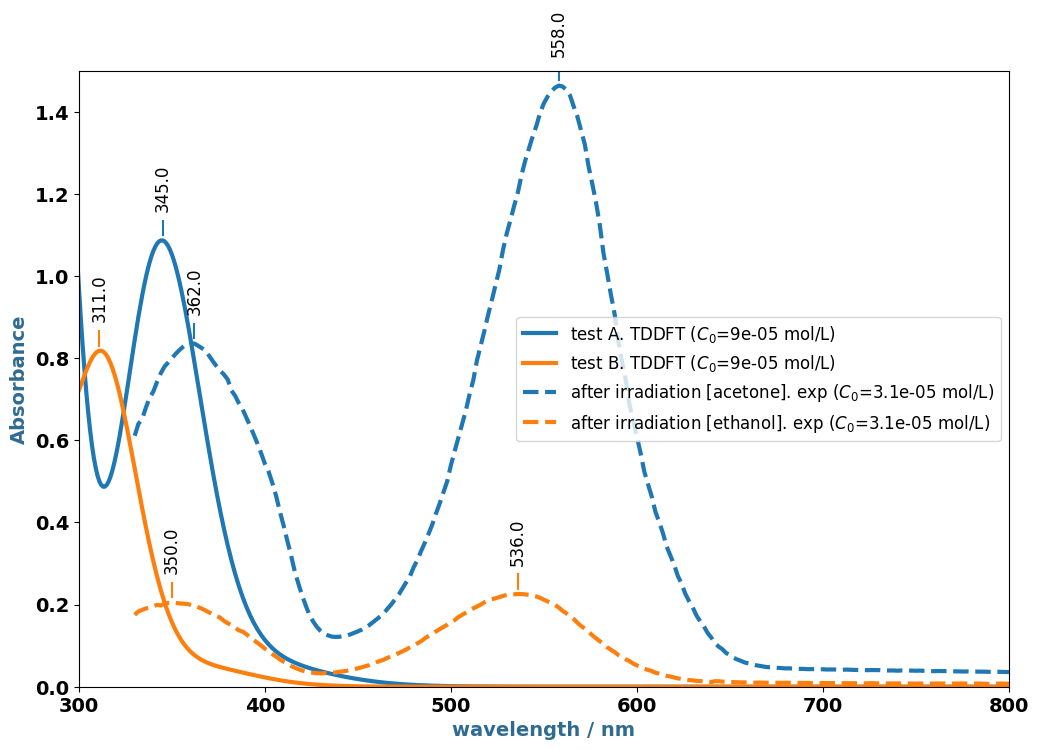

In [123]:
# Same as previous, but with the SpectrumSimulator class of tools4pyPhysChem
import tools4pyPhysChem
from tools4pyPhysChem import SpectrumSimulator
from importlib import reload
reload(tools4pyPhysChem)

sim = SpectrumSimulator(plotWH=(12,8))

#### Both for TDDFT and exp spectra
lambdaMin = 300
lambdaMax = 800
Amax = 1.5

#### TDDFT
datFilesTDDFT = ["./EasterEgg/test-tabA.dat","./EasterEgg/test-tabB.dat"]
C0theo = [9e-5]*2
titlesTDDFT = ["test A", "test B"]
sim.plotAbs_lambda_TDDFT(datFilesTDDFT, C0theo, lambdaMin, lambdaMax, Amax, titlesTDDFT)

#### exp
csvFilesExp = ["./EasterEgg/ExpAbsSpectrumAc.csv","./EasterEgg/ExpAbsSpectrumEtOH.csv"]
C0exp = [3.1e-5]*2
titlesExp = ["after irradiation [acetone]", "after irradiation [ethanol]"]
sim.plotAbs_lambda_exp(csvFiles=csvFilesExp, C0=C0exp, titles=titlesExp)

## ZnTPP and derivatives

### ZnTPP

#### The molecule

##### 2D representation

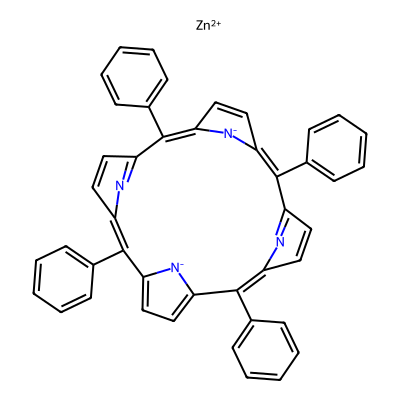

In [7]:
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.molSize = 400,400
ZnTPP = "C1=CC=C(C=C1)C2=C3C=CC(=C(C4=NC(=C(C5=CC=C([N-]5)C(=C6C=CC2=N6)C7=CC=CC=C7)C8=CC=CC=C8)C=C4)C9=CC=CC=C9)[N-]3.[Zn+2]"
ZnTPP = Chem.MolFromSmiles(ZnTPP)
ZnTPP

<div class="rqE">

Some molecules like macrocycles are not represented well using the default RDKit drawing code. As a result, it may be preferable to use the `CoordGen` integration.
</div>

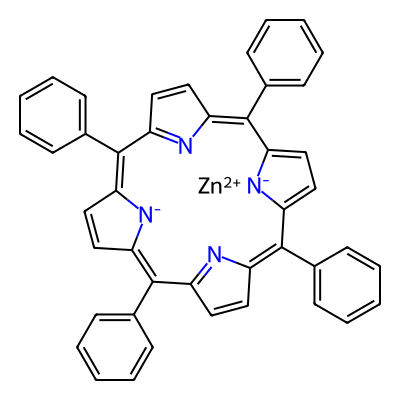

In [8]:
from rdkit.Chem import rdCoordGen
rdCoordGen.AddCoords(ZnTPP)
ZnTPP

##### 3D structure, optimized at the DFT level of theory, using the PBE0 functional

In [9]:
import py3Dmol
MolView = py3Dmol.view(width=600,height=600)
with open("./EasterEgg/ZnTPP/ZnTPP-TDDDFT_OPT.xyz") as ifile:
    mol = ifile.read()
MolView.addModel(mol)
MolView.setStyle({'sphere':{'scale':0.3},'stick':{}})
MolView.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### Plot of epsilon = f($\lambda$)

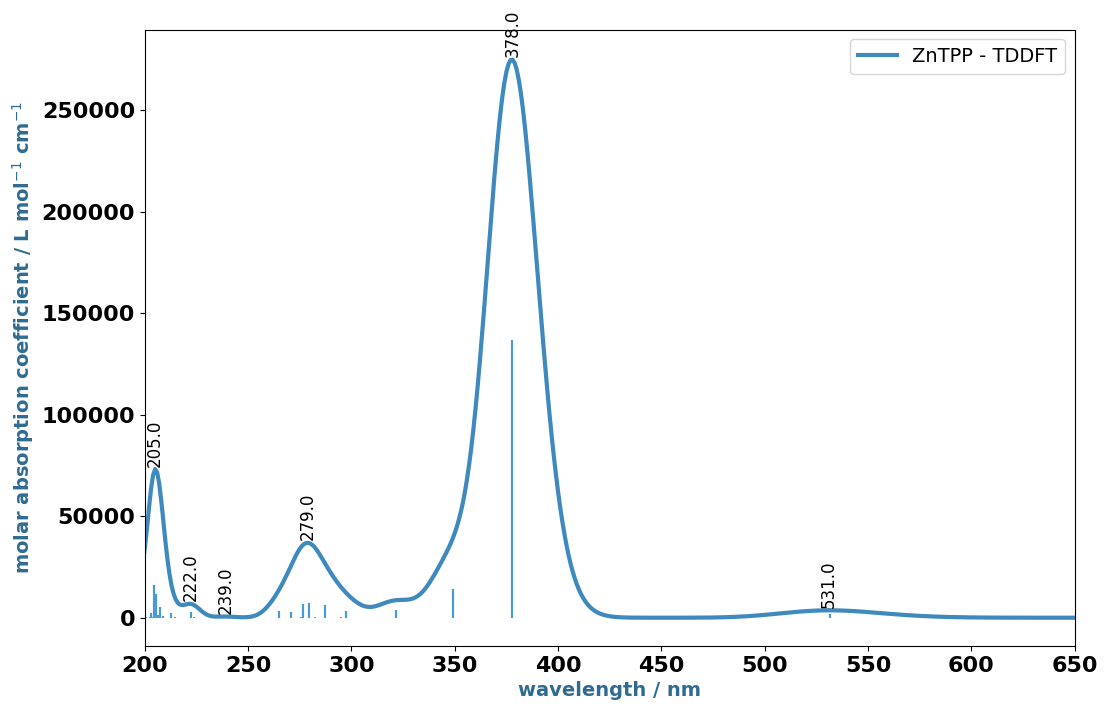

ZnTPP - TDDFT
peak   0.  191 nm. epsilon_max = 17981.9 L mol-1 cm-1
peak   1.  205 nm. epsilon_max = 73142.1 L mol-1 cm-1
peak   2.  222 nm. epsilon_max = 6842.7 L mol-1 cm-1
peak   3.  239 nm. epsilon_max = 581.7 L mol-1 cm-1
peak   4.  279 nm. epsilon_max = 36870.8 L mol-1 cm-1
peak   5.  378 nm. epsilon_max = 274760.7 L mol-1 cm-1
peak   6.  531 nm. epsilon_max = 3649.0 L mol-1 cm-1


In [10]:
plotEps_lambda_TDDFT("./EasterEgg/ZnTPP/ZnTPP-TDDDFT_ExcStab.dat",200,650,"ZnTPP - TDDFT", 10, 0.15, False)

#### Plot of A = f($\lambda$)

TDDFT. ZnTPP - TDDFT
peak   0.  279 nm. A = 0.18
peak   1.  378 nm. A = 1.37


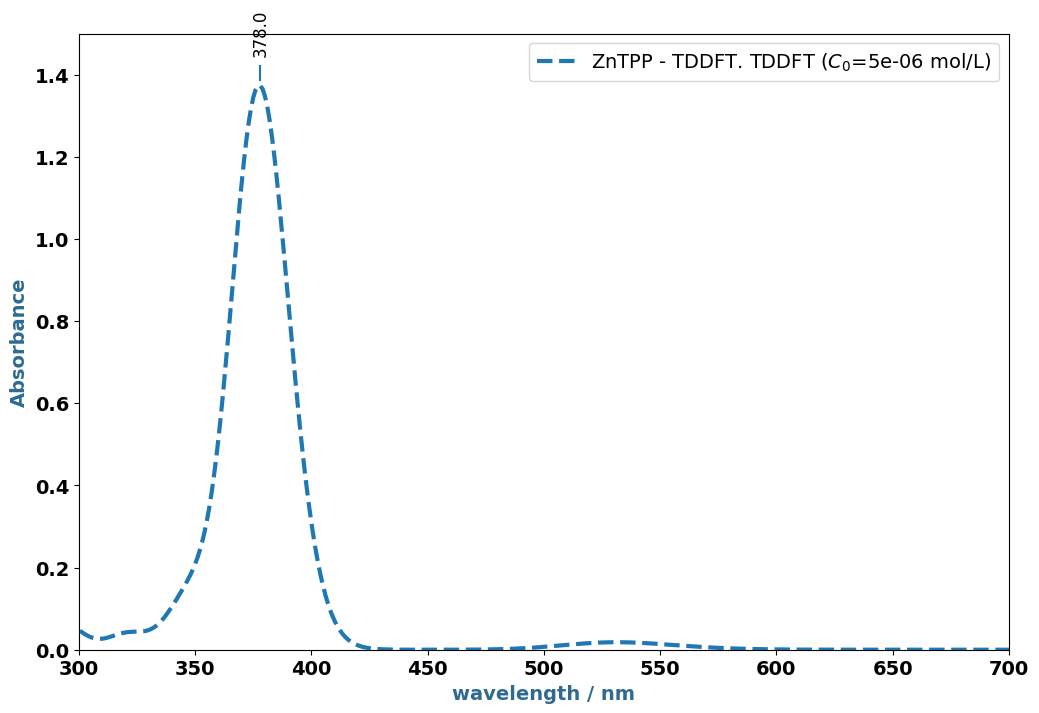

In [11]:
#### Both for TDDFT and exp spectra
fig, graph = initializePlotA_lambda(12, 8)
lambdaMin = 300
lambdaMax = 700
Amax = 1.5

#### TDDFT
dataFilesTDDFT = ["./EasterEgg/ZnTPP/ZnTPP-TDDDFT_ExcStab.dat"]
C0theo = [5e-6]
titlesTDDFT = ["ZnTPP - TDDFT"]
plotAbs_lambda_TDDFT(graph, dataFilesTDDFT, C0theo, lambdaMin, lambdaMax, Amax, titlesTDDFT, sigma=0.15)

#### exp
# csvFilesExp = ["./EasterEgg/ExpAbsSpectrumAc.csv","./EasterEgg/ExpAbsSpectrumEtOH.csv"]
# C0exp = [3.1e-5]*2
# titlesExp = ["after irradiation [acetone]", "after irradiation [ethanol]"]
# replotAbs_lambda_exp(graph, True, csvFilesExp, C0exp, lambdaMin, lambdaMax, Amax, titlesExp)

### ZnTPP-NO2

#### 3D structure, optimized at the DFT level of theory, using the PBE0 functional

In [10]:
import py3Dmol
MolView = py3Dmol.view(width=600,height=600)
with open("./EasterEgg/ZnTPP/ZnTPP-NO2-TDDDFT_OPT.xyz") as ifile:
    mol = ifile.read()
MolView.addModel(mol)
MolView.setStyle({'sphere':{'scale':0.3},'stick':{}})
MolView.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### Plot of epsilon = f($\lambda$)

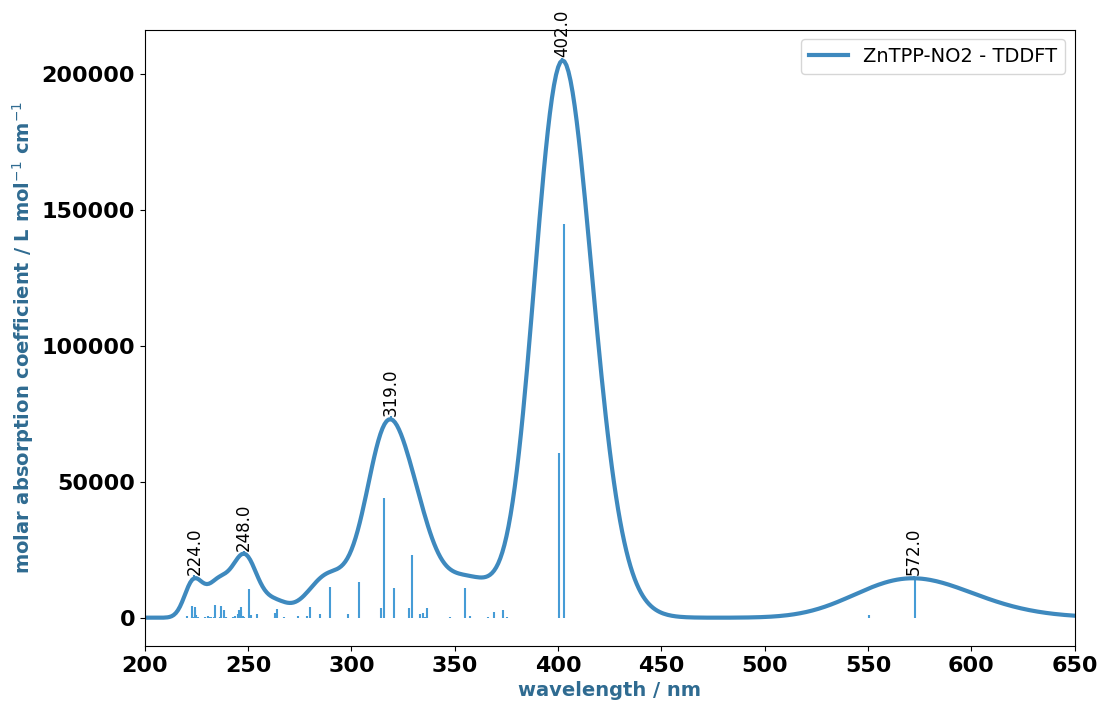

ZnTPP-NO2 - TDDFT
peak   0.  224 nm. epsilon_max = 14536.3 L mol-1 cm-1
peak   1.  248 nm. epsilon_max = 23552.7 L mol-1 cm-1
peak   2.  319 nm. epsilon_max = 72975.9 L mol-1 cm-1
peak   3.  402 nm. epsilon_max = 204862.5 L mol-1 cm-1
peak   4.  572 nm. epsilon_max = 14503.7 L mol-1 cm-1


In [11]:
plotEps_lambda_TDDFT("./EasterEgg/ZnTPP/ZnTPP-NO2-TDDDFT_ExcStab.dat",200,650,"ZnTPP-NO2 - TDDFT", 10, 0.15, False)

#### Plot of A = f($\lambda$)

TDDFT. ZnTPP-NO2 - TDDFT
peak   0.  319 nm. A = 0.36
peak   1.  402 nm. A = 1.02


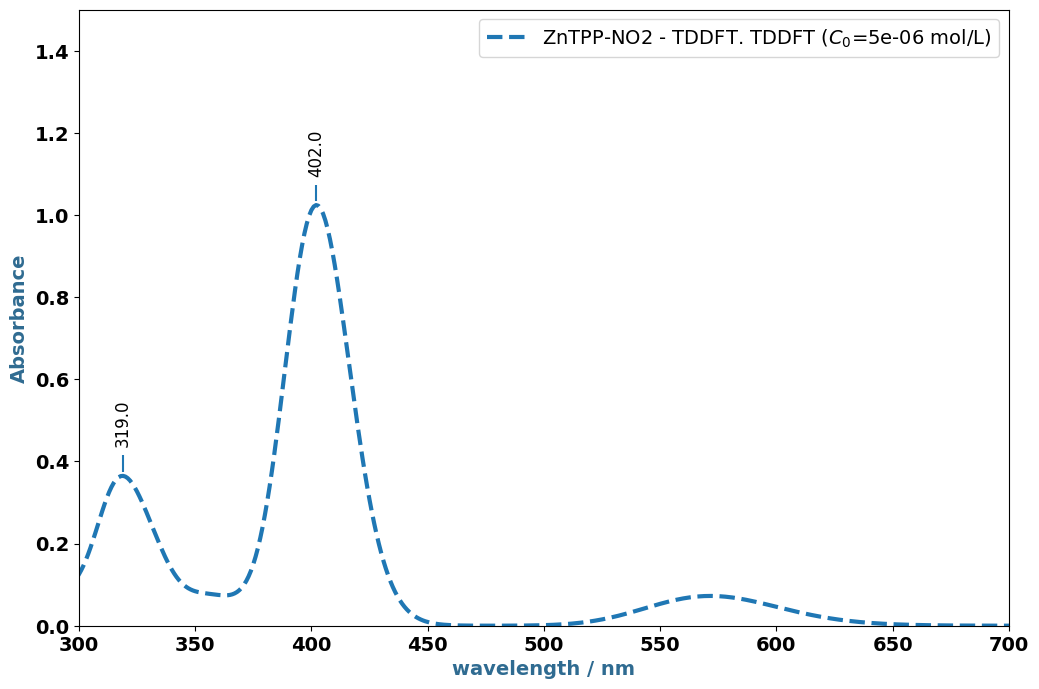

In [12]:
#### Both for TDDFT and exp spectra
fig, graph = initializePlotA_lambda(12, 8)
lambdaMin = 300
lambdaMax = 700
Amax = 1.5

#### TDDFT
dataFilesTDDFT = ["./EasterEgg/ZnTPP/ZnTPP-NO2-TDDDFT_ExcStab.dat"]
C0theo = [5e-6]
titlesTDDFT = ["ZnTPP-NO2 - TDDFT"]
plotAbs_lambda_TDDFT(graph, dataFilesTDDFT, C0theo, lambdaMin, lambdaMax, Amax, titlesTDDFT, sigma=0.15)

## Try it for yourself!

In [13]:
# insert your code here...

In [14]:
vID.end(cwd0)

**End at:** Wednesday 19 March 2025, 13:33:10  
**Duration:** 00:02:18 931ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>